In [21]:
import h5py
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch

In [3]:
pions1 = h5py.File('/fast_scratch/QVAE/data/atlas/pions1.hdf5','r')
photons1 = h5py.File('/fast_scratch/QVAE/data/atlas/photons1.hdf5','r')
photons2 = h5py.File('/fast_scratch/QVAE/data/atlas/photons2.hdf5','r')

Unpacking and setting up

In [5]:
pions1_voxels = torch.tensor(pions1["voxels"][:])
pi_true_energy = torch.tensor(pions1["energy"][:])
energy_list = torch.unique(pi_true_energy)
print(energy_list)
#print(pions1_voxels[3,:].unsqueeze(0))

tensor([2.5600e+02, 5.1200e+02, 1.0240e+03, 2.0480e+03, 4.0960e+03, 8.1920e+03,
        1.6384e+04, 3.2768e+04, 6.5536e+04, 1.3107e+05, 2.6214e+05, 5.2429e+05,
        1.0486e+06, 2.0972e+06, 4.1943e+06], dtype=torch.float64)


Using tensors

In [14]:
pion_layers = np.array([0, 8, 108, 208, 213, 363, 523, 533])
photon_layers = torch.tensor([0, 8, 168, 358, 363, 368])
pion_lower_lim = pion_layers[0:-1]
pion_upper_lim = pion_layers[1:]
photon_upper_lim = photon_layers[1:]
photon_lower_lim = photon_layers[0:-1]

def Get_Sparsity(pions1_voxels, lower_lim, upper_lim, layers):

    #layers_sparsities = np.zeros((pions1_voxels.shape[0], len(pion_layers)-1), dtype=np.float32)
    layer_datasets = [pions1_voxels[0][start_idx:end_idx] for start_idx, end_idx in zip(lower_lim, upper_lim)]
    layer_sp = [abs(np.count_nonzero(layer_dataset)/layer_dataset.shape[0]-1) for layer_dataset in layer_datasets]
    data_sparsities = torch.tensor(layer_sp)

    for i in range(1, pions1_voxels.shape[0]): #looping over all events
        layer_datasets = [pions1_voxels[i][start_idx:end_idx] for start_idx, end_idx in zip(pion_lower_lim, pion_upper_lim)]
        layer_sp = [abs(np.count_nonzero(layer_dataset)/layer_dataset.shape[0]-1) for layer_dataset in layer_datasets]
        data_sparsities = torch.cat((data_sparsities, torch.tensor(layer_sp)), dim=0)

    data_sparsities = data_sparsities.reshape(pions1_voxels.shape[0], len(layers)-1)
    return data_sparsities

Creating tensor with unique incident energy

In [15]:
unique_energies = np.array([2.5600e+02, 5.1200e+02, 1.0240e+03, 2.0480e+03, 4.0960e+03, 8.1920e+03,
        1.6384e+04, 3.2768e+04, 6.5536e+04, 1.3107e+05, 2.6214e+05, 5.2429e+05,
        1.0486e+06, 2.0972e+06, 4.1943e+06])
def Get_Unique_Energy_Events(pions1_voxels, unique_energy):
    unique_energy_tensor = torch.tensor([])
    dataset = pions1_voxels
    for i in range(pi_true_energy.shape[0]):
        if pi_true_energy[i] == unique_energy:
            unique_energy_tensor = torch.cat((unique_energy_tensor, dataset[i,:].unsqueeze(0)), dim=0)
    print(unique_energy_tensor.shape, unique_energy)
    return unique_energy_tensor
#This gives a tensor with events of that specific energy! Now compute sparsity of layers for each event:

Generate datasets with unique energy events

In [16]:
Unique_Energies_data = [Get_Unique_Energy_Events(pions1_voxels, x) for x in energy_list]

torch.Size([10000, 533]) tensor(256., dtype=torch.float64)
torch.Size([10000, 533]) tensor(512., dtype=torch.float64)
torch.Size([10000, 533]) tensor(1024., dtype=torch.float64)
torch.Size([10000, 533]) tensor(2048., dtype=torch.float64)
torch.Size([10000, 533]) tensor(4096., dtype=torch.float64)
torch.Size([10000, 533]) tensor(8192., dtype=torch.float64)
torch.Size([10000, 533]) tensor(16384., dtype=torch.float64)
torch.Size([10000, 533]) tensor(32768., dtype=torch.float64)
torch.Size([10000, 533]) tensor(65536., dtype=torch.float64)
torch.Size([10000, 533]) tensor(131072., dtype=torch.float64)
torch.Size([10000, 533]) tensor(262144., dtype=torch.float64)
torch.Size([5000, 533]) tensor(524288., dtype=torch.float64)
torch.Size([3000, 533]) tensor(1048576., dtype=torch.float64)
torch.Size([2000, 533]) tensor(2097152., dtype=torch.float64)
torch.Size([230, 533]) tensor(4194304., dtype=torch.float64)


Calculating sparsities for datasets

In [17]:
Unique_sparsities = [Get_Sparsity(x, pion_lower_lim, pion_upper_lim, pion_layers) for x in Unique_Energies_data]
print(Unique_sparsities[0])

tensor([[0.8750, 0.7000, 0.9100,  ..., 1.0000, 1.0000, 1.0000],
        [0.7500, 0.9200, 0.9300,  ..., 1.0000, 0.9875, 1.0000],
        [0.6250, 0.9400, 0.9800,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [0.7500, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [0.8750, 0.9000, 0.9000,  ..., 1.0000, 1.0000, 1.0000],
        [0.5000, 0.9700, 0.9400,  ..., 1.0000, 1.0000, 1.0000]])


In [18]:
tensor = Unique_sparsities[5]  #roughly 8GeV
print(torch.mean(tensor, dim=0))

tensor([0.5510, 0.6960, 0.4107, 0.2615, 0.7524, 0.8338, 0.9287])


Average sparsity for each layer

/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:2826: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:2826: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


ValueError: x and y must be the same size

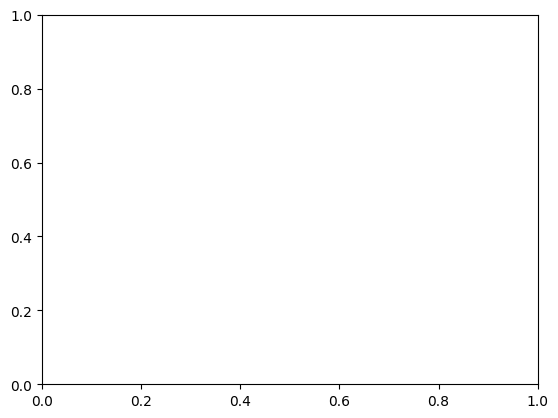

In [26]:
average_sparsities = [torch.mean(x, dim=0) for x in Unique_sparsities]
average_frac_energies = [torch.mean(GeV, dim=0) for GeV in GeV_list]
Layer_list = [1, 2, 3, 4, 5, 6, 7]
#plt.plot(Layer_list, , cmap = average_frac_energies)

plt.scatter(Layer_list, average_sparsities, s = 200*average_frac_energies)
plt.ylabel('Average Sparsity')
plt.xlabel('Layer')
plt.title('0.25GeV incident energy')
plt.show()

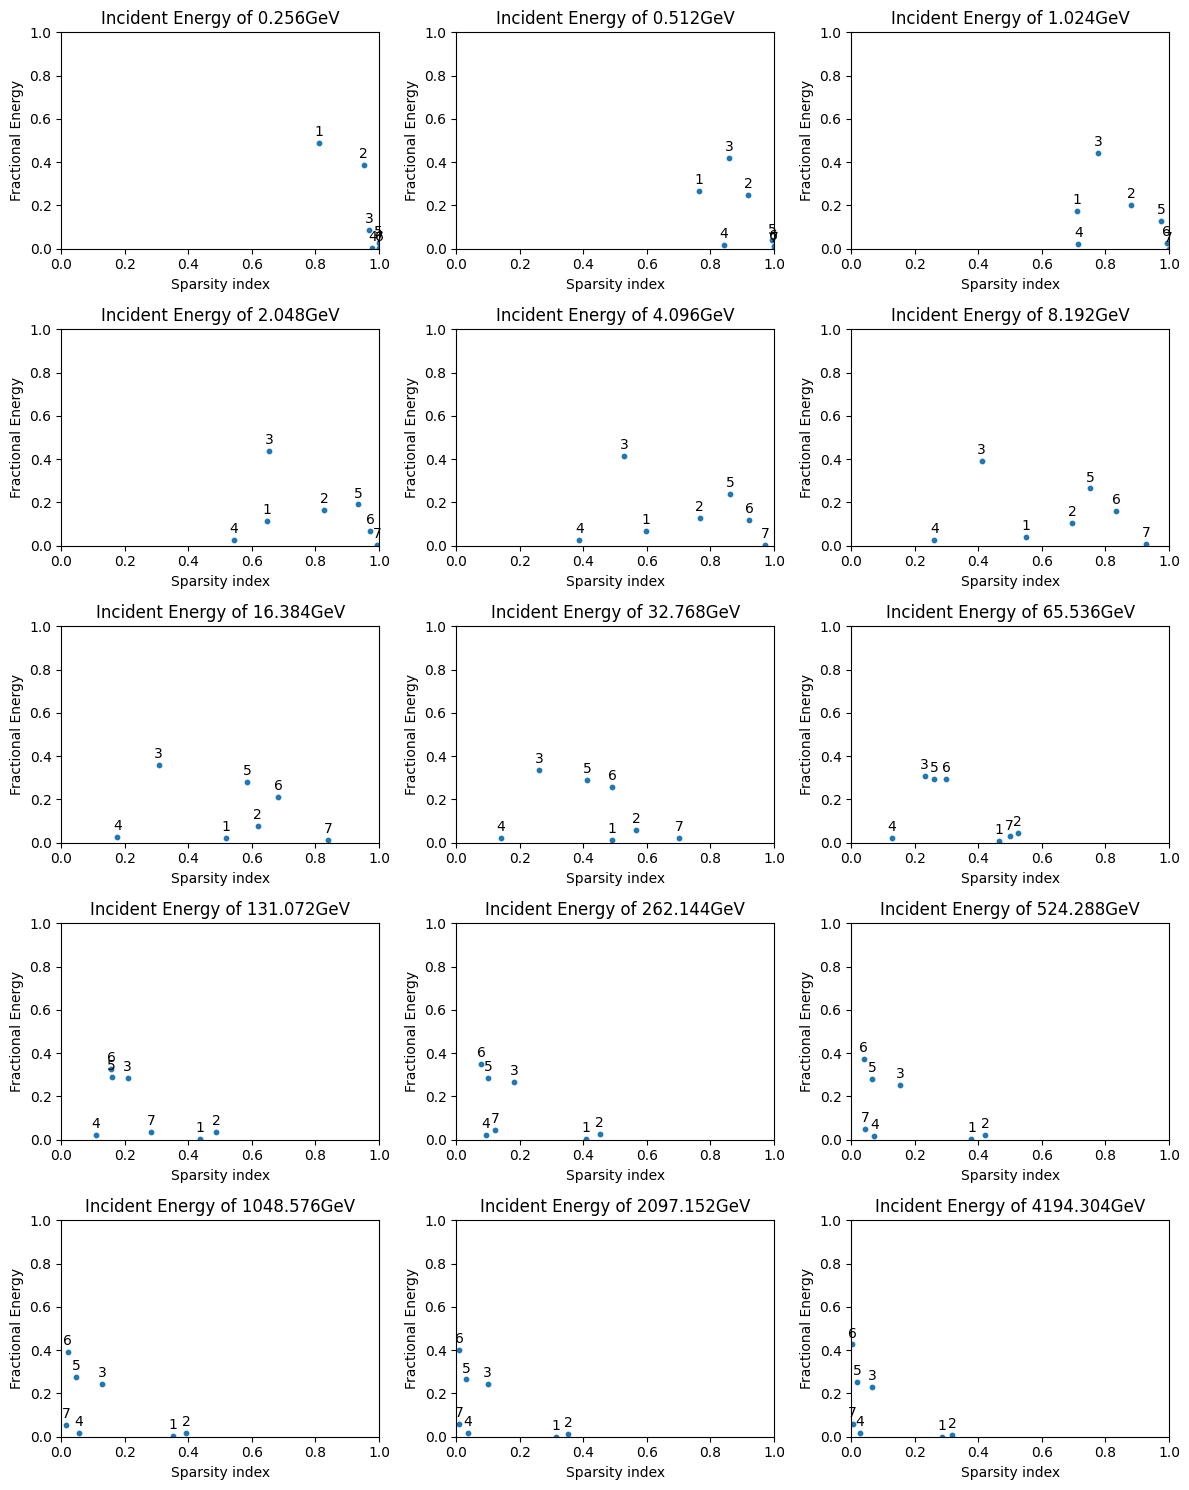

In [27]:
num_rows = 5
num_cols = 3
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 15))

# Flatten the axes to iterate over the subplots
axes = axes.flatten()

# Iterate through the data_list and plot scatter plots
for i, data in enumerate(average_frac_energies):
    row = i // num_cols
    col = i % num_cols
    ax = axes[i]

    ax.scatter(average_sparsities[i], data, s=10, marker='o')#, c = Layer_list)
    
    for j, (x, y) in enumerate(zip(average_sparsities[i], data)):
        ax.annotate(f'{j+1}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center')
    
    ax.set_xlabel('Sparsity index')
    ax.set_ylabel('Fractional Energy')
    ax.set_xlim(0., 1.)
    ax.set_ylim(0., 1.)
    ax.set_title(f'Incident Energy of {energy_list[i]/1000}GeV')
    #ax.legend()

# Hide any empty subplots if the number of scatter plots is less than the grid size
for i in range(len(average_frac_energies), num_rows * num_cols):
    fig.delaxes(axes[i])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
plt.scatter(average_sparsities, average_frac_energies)
counter = 0
for x, y in zip(average_sparsities, average_frac_energies):
    counter += 1
    plt.text(x, y, counter)
plt.xlabel('Average sparsity')
plt.ylabel('Average Fractional Energy Deposition')
plt.title("")
plt.show()

Plotting all energies for single layers

tensor([0.3062])
tensor([0.5850])
tensor([0.6826])


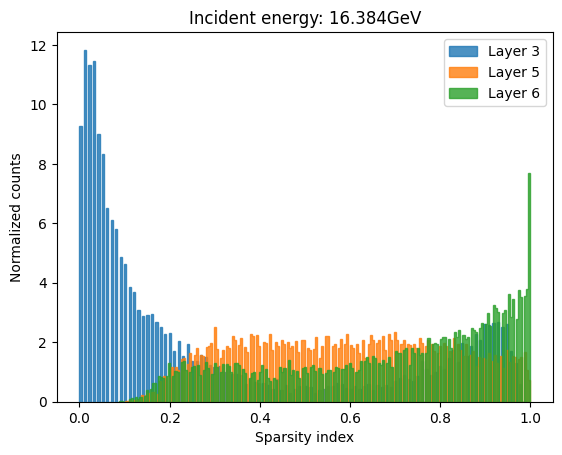

In [29]:
for layer_n in [3, 5, 6]: 
#layer_n = 3
    idx = 6  #energy_index in energy_list
    #for idx in range(len(Unique_sparsities)):
    energy_to_display = unique_energies[idx]
    data = Unique_sparsities[idx]
    #weights = np.ones_like(tensor[:, layer_n-1])/float(pions1_voxels.shape[0])   #dividing by total number of pion events to normalize histogram over all events
    weights = np.ones_like(data[:, layer_n-1])/float(len(data[:, layer_n-1])*3) #for individual layers
    #plt.hist(torch.log(data[:, layer_n-1]+epsilon), bins=200, weights=weights, label = f'Layer: {layer_n}', histtype='step', stacked=True, fill=True)
    plt.hist(data[:, layer_n-1], bins=200, weights=weights, alpha=0.8, label = f'Layer {layer_n}', histtype='step', stacked=True, fill=True, density=True)
    plt.ylabel("Normalized counts")
    plt.xlabel("Sparsity index")
    plt.title(f'Incident energy: {energy_to_display/1000}GeV')
    plt.legend()
    print(torch.mean(data[:, layer_n-1].unsqueeze(0), dim=1))
plt.show()



Plotting all layers for all energies

In [28]:
pion_voxel_num = np.array([8, 100, 100, 5, 150, 60, 10])
photon_voxel_num = np.array([8, 160, 190, 5, 5])
data_sparsities = Get_Sparsity(pions1_voxels, pion_lower_lim, pion_upper_lim, pion_layers)
#for idx in range(len(pion_layers)-1):
    #weights = np.ones_like(data_sparsities[:, idx])/float(len(data_sparsities[:, idx]))
    #plt.hist(data_sparsities[:, idx], bins=100, weights=weights, stacked=True, label = f'Layer {idx+1} with {pion_voxel_num[idx]} voxels')
idx = 0
weights = np.ones_like(data_sparsities[:, 'layer number'])/float(len(data_sparsities[:, 'layer number']))
plt.hist(data_sparsities[:, idx], bins=100, weights=weights, stacked=True, label = f'Layer {idx+1} with {pion_voxel_num[idx]} voxels')
plt.ylabel("Normalized counts")
plt.xlabel("Sparsity index")
plt.title("Pions1 data for Layer 1")
plt.legend()
plt.show()

TypeError: new(): invalid data type 'str'

Creating colour map (first calculate fraction of energy deposited in each layer for all energy events).
The size of this tensor will be the same as for sparsity as each event has 7 fractions each corresponding to the fraction of total deposited energy in the calorimeter for a single layer. Thus we can use the unique energy events list to create to find deposition fractions over all events for a particular energy. The mean of these can then be taken to create a colour map. (The structure of Get_Sparsity() will come in handy here).

In [20]:
epsilon = 1e-6
def Get_Fractional_Energy_per_Layer_per_Energy(idx, lower_lim, upper_lim, layers, epsilon):
    #idx chooses specific energy from energy_list defined above
    
    dataset = Unique_Energies_data[idx]   #change from pions to photons here
    
    layer_datasets = [dataset[0][start_idx:end_idx] for start_idx, end_idx in zip(lower_lim, upper_lim)]
    layer_frac = [torch.sum(layer_dataset, dim=0)/torch.sum(dataset[0], dim=0) for layer_dataset in layer_datasets]
    frac_e_per_layer = torch.tensor(layer_frac)
    
    reshape_counter = 0  #removing events where 0 energy is deposited in the calorimeter with if/else statement in loop
    for i in range(1, dataset.shape[0]): #looping over all events
        if torch.sum(dataset[i]) != 0.:
            layer_datasets = [dataset[i][start_idx:end_idx] for start_idx, end_idx in zip(lower_lim, upper_lim)]
            layer_frac = [torch.sum(layer_dataset, dim=0)/(torch.sum(dataset[i], dim=0)+epsilon) for layer_dataset in layer_datasets]
            frac_e_per_layer = torch.cat((frac_e_per_layer, torch.tensor(layer_frac)), dim=0)
        else:
            reshape_counter += 1
        
    frac_e_per_layer = frac_e_per_layer.reshape(dataset.shape[0]-reshape_counter, len(layers)-1)
    return frac_e_per_layer


#GeV = Get_Fractional_Energy_per_Layer_per_Energy(5, pion_lower_lim, pion_upper_lim, pion_layers, epsilon)
#print(GeV.shape)

10000


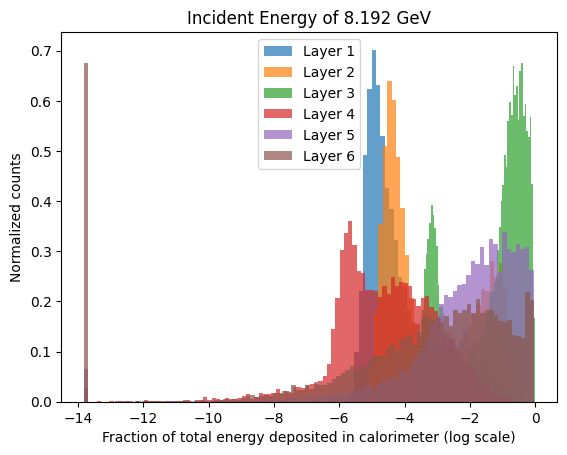

In [25]:
print(GeV16.shape[0])
for i in range(GeV8.shape[1]-1):
#for i in [5,4,2,1]:
    #weights = (np.ones_like(GeV[:,i])+epsilon)/float(GeV.shape[0]*(GeV.shape[1]-1))
    plt.hist(torch.log(GeV8[:,i]+epsilon), bins=100, label = f'Layer {i+1}', alpha=0.7, density=True)
    #plt.hist(GeV[:,i], weights=weights, bins=100, label = f'Layer {i+1}', alpha=0.8, density=True)
plt.xlabel('Fraction of total energy deposited in calorimeter (log scale)')
plt.ylabel('Normalized counts')
plt.title(f'Incident Energy of {energy_list[5]/1000} GeV')
#plt.xlim(0., 1.)
#plt.ylim(0, 0.042)
plt.legend()
plt.show()

In [22]:
GeV02 = Get_Fractional_Energy_per_Layer_per_Energy(0, pion_lower_lim, pion_upper_lim, pion_layers, epsilon)
GeV05 = Get_Fractional_Energy_per_Layer_per_Energy(1, pion_lower_lim, pion_upper_lim, pion_layers, epsilon)
GeV1 = Get_Fractional_Energy_per_Layer_per_Energy(2, pion_lower_lim, pion_upper_lim, pion_layers, epsilon)
GeV2 = Get_Fractional_Energy_per_Layer_per_Energy(3, pion_lower_lim, pion_upper_lim, pion_layers, epsilon)
GeV4 = Get_Fractional_Energy_per_Layer_per_Energy(4, pion_lower_lim, pion_upper_lim, pion_layers, epsilon)
GeV8 = Get_Fractional_Energy_per_Layer_per_Energy(5, pion_lower_lim, pion_upper_lim, pion_layers, epsilon)
GeV16 = Get_Fractional_Energy_per_Layer_per_Energy(6, pion_lower_lim, pion_upper_lim, pion_layers, epsilon)
GeV33 = Get_Fractional_Energy_per_Layer_per_Energy(7, pion_lower_lim, pion_upper_lim, pion_layers, epsilon)
GeV66 = Get_Fractional_Energy_per_Layer_per_Energy(8, pion_lower_lim, pion_upper_lim, pion_layers, epsilon)
GeV131 = Get_Fractional_Energy_per_Layer_per_Energy(9, pion_lower_lim, pion_upper_lim, pion_layers, epsilon)
GeV262 = Get_Fractional_Energy_per_Layer_per_Energy(10, pion_lower_lim, pion_upper_lim, pion_layers, epsilon)
GeV524 = Get_Fractional_Energy_per_Layer_per_Energy(11, pion_lower_lim, pion_upper_lim, pion_layers, epsilon)
GeV1049 = Get_Fractional_Energy_per_Layer_per_Energy(12, pion_lower_lim, pion_upper_lim, pion_layers, epsilon)
GeV2097 = Get_Fractional_Energy_per_Layer_per_Energy(13, pion_lower_lim, pion_upper_lim, pion_layers, epsilon)
GeV4194 = Get_Fractional_Energy_per_Layer_per_Energy(14, pion_lower_lim, pion_upper_lim, pion_layers, epsilon)


In [30]:
GeV_list = [GeV02, GeV05, GeV1, GeV2, GeV4, GeV8, GeV16, GeV33, GeV66, GeV131, GeV262, GeV524, GeV1049, GeV2097, GeV4194]
print(torch.mean(GeV8, dim=0))
print(torch.mean(GeV16, dim=0))
print(torch.mean(GeV33, dim=0))
#print(torch.sum(torch.mean(GeV8, dim=0)))

tensor([0.0417, 0.1049, 0.3914, 0.0264, 0.2645, 0.1626, 0.0084],
       dtype=torch.float64)
tensor([0.0238, 0.0790, 0.3609, 0.0258, 0.2829, 0.2129, 0.0147],
       dtype=torch.float64)
tensor([0.0141, 0.0593, 0.3342, 0.0241, 0.2904, 0.2560, 0.0219],
       dtype=torch.float64)


Energy deposition in solely layers 3, 5, 6 for pions

In [12]:
hi = [torch.mean(x, dim=0) for x in GeV_list]
print([hi[x][2]+hi[x][4]+hi[x][5] for x in range(len(hi))])

NameError: name 'GeV_list' is not defined

Testing the effect of Abhishek's scaling on sparsity information in input data

In [4]:
gf = h5py.File('/fast_scratch/QVAE/data/atlas_dataset2and3/dataset_2_1.hdf5', 'r')
pf = h5py.File('/fast_scratch/QVAE/data/atlas_dataset2and3/dataset_3_1.hdf5', 'r')

In [5]:
hdfs = [gf,pf]
nplcats = []
nplcats_energies = []

In [12]:
for hdf in hdfs:
    npl0 = np.array(hdf['showers'])
    npl1 = np.array(hdf['incident_energies'])
    print('a')
    npl0 = npl0.reshape(npl0.shape[0], -1)
    npl1 = npl1.reshape(npl1.shape[0], -1)
    print('b')
    nplcats.append(np.concatenate([npl0], axis=1))
    print('c')
    nplcats_energies.append(np.concatenate([npl1], axis=1))

a
b
c
a
b
c


In [7]:
nplcatscaled = []
transformers = []
arrmins = [[], [], []]
epsilon = 1e-2
print('checkpoint')

for i in range(len(nplcats)):
    print(i)
    nparr = nplcats[i]
    nparr = np.where(nparr > 0., nparr, np.nan)
    transformer = StandardScaler().fit(nparr)
    nparr = transformer.transform(nparr)
    transformers.append(transformer)
    
    nparr = np.where(np.isnan(nparr), np.inf, nparr)
    
    for j in range(nparr.shape[1]):
        arrmin = np.amin(nparr[:, j])
        
        if arrmin < 0 and not np.isnan(arrmin):
            nparr[:, j] -= arrmin
            nparr[:, j] += epsilon
            arrmins[i].append(arrmin)
        else:
            arrmins[i].append(0.)
            
    nparr = np.where(np.isinf(nparr), 0, nparr)
    
    for j in range(nparr.shape[1]):
        arrmin = np.amin(nparr[:, j])
        if arrmin < 0:
            print(j, arrmin)

    nplcatscaled.append(nparr)

checkpoint
0
1


In [8]:
print(max(nplcatscaled[0][100]))

7.189884971873329


In [10]:
gf_scaled = h5py.File('/fast_scratch/QVAE/data/atlas_dataset2and3/dataset_2_1_scaled.hdf5', 'w')
pf_scaled = h5py.File('/fast_scratch/QVAE/data/atlas_dataset2and3/dataset_3_1_scaled.hdf5', 'w')
hdfs_scaled = [gf_scaled, pf_scaled]
# hdfs_scaled = [ef_scaled, gf_scaled, pf_scaled]
layer_shapes = {}
for hdf in hdfs:
    for key in hdf.keys():
        if key == "energy" or key == "overflow" or key == "energy_from_voxels" or key == "showers" or "incident_energies":
            pass
        else:
   #         layer_shapes[key] = hdf[key].shape
             layer_shapes[hdf] = {key : hdf[key].shape}

In [13]:
for hdf, hdf_scaled, scaled_data, incident_energies in zip(hdfs, hdfs_scaled, nplcatscaled, nplcats_energies):
    offset = 0
    for key in hdf.keys():
        if key == "showers":
            hdf_scaled.create_dataset(key, data=scaled_data)
        elif key == "incident_energies":
            hdf_scaled.create_dataset(key, data=incident_energies)
        '''else:
            layer_shape = layer_shapes[hdf][key]
            print("###########")
            print(layer_shape)
            print(scaled_data.shape)
#             layer_data = scaled_data[:, offset:offset+(layer_shape[1]*layer_shape[2])]
            layer_data = scaled_data[:, offset:offset+layer_shape[1]]
            print(layer_data.shape)
            layer_data = layer_data.reshape(layer_shape)
            hdf_scaled.create_dataset(key, data=layer_data)
#             offset += layer_shape[1]*layer_shape[2]
            offset += layer_shape[1]'''

In [14]:
for hdf_scaled in hdfs_scaled:
    for key in hdf_scaled.keys():
        print(key, hdf_scaled[key].shape, hdf_scaled[key].dtype)
        
for hdf_scaled in hdfs_scaled:
    hdf_scaled.close()

incident_energies (100000, 1) float64
showers (100000, 6480) float64
incident_energies (50000, 1) float64
showers (50000, 40500) float64


In [15]:
nplcatinv = []

for i in range(len(nplcatscaled)):
    nparr = nplcatscaled[i]
    nparr = np.where(nparr > 0., nparr, np.nan)
    print('check1')
    for j in range(nparr.shape[1]):
        arrmin = arrmins[i][j]
        if arrmin < 0. and not np.isnan(arrmin):
            nparr[:, j] -= epsilon
            nparr[:, j] += arrmin
    print('check2')
    transformer = transformers[i]
    nparr = transformer.inverse_transform(nparr)
    print('check3')
    nparr = np.where(np.isinf(nparr), 0, nparr)
    nplcatinv.append(nparr)


check1
check2
check3
check1
check2
check3


In [ ]:
for i in range(len(nplcatinv)):
    nparrorig = nplcats[i]
    nparrinv = nplcatinv[i]
    
    for j in range(nparrorig.shape[1]):
        diff = np.sum(nparrorig[:, j] - nparrinv[:, j])
        if diff > 0:
            print(i, j, diff)
            
params = transformers[0].get_params()

In [ ]:
import joblib

# joblib.dump(transformers[0], 'scaler.gz')
# transformer = joblib.load('scaler.gz')

joblib.dump(transformers[0], '/fast_scratch/QVAE/data/atlas_dataset2and3/dataset_2_1_scaler.gz')
joblib.dump(transformers[1], '/fast_scratch/QVAE/data/atlas_dataset2and3/dataset_3_1_scaler.gz')

In [ ]:
ld_transformers = []
ld_transformers.append(joblib.load('/fast_scratch/QVAE/data/atlas_dataset2and3/dataset_2_1_scaler.gz'))
ld_transformers.append(joblib.load('/fast_scratch/QVAE/data/atlas_dataset2and3/dataset_3_1_scaler.gz'))

nplcatinv = []

for i in range(len(nplcatscaled)):
    nparr = nplcatscaled[i]
    nparr = np.where(nparr > 0., nparr, np.inf)
    
    for j in range(nparr.shape[1]):
        arrmin = arrmins[i][j]
        if arrmin < 0. and not np.isnan(arrmin):
            nparr[:, j] -= epsilon
            nparr[:, j] += arrmin
            
    transformer = ld_transformers[i]
    nparr = transformer.inverse_transform(nparr)
    
    nparr = np.where(np.isnan(nparr), 0, nparr)
    nplcatinv.append(nparr)

In [ ]:
for i in range(len(nplcatinv)):
    nparrorig = nplcats[i]
    nparrinv = nplcatinv[i]
    
    for j in range(nparrorig.shape[1]):
        diff = np.sum(nparrorig[:, j] - nparrinv[:, j])
        if diff > 1e-4:
            print(i, j, diff)

In [ ]:
for i, ptype in enumerate(["dataset_2_1", "dataset_3_1"]):
    filepath = "/fast_scratch/QVAE/data/atlas_dataset2and3/" + ptype + "_amin.npy"
    with open(filepath, 'wb') as f:
        np.save(f, arrmins[i])